In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image 
import rawpy
import math
import scipy as sp
import scipy.optimize

In [11]:
path1 = 'T_S04857.ARW'
path2 = 'depthT_S04857.tif'

(5320, 7968, 3)


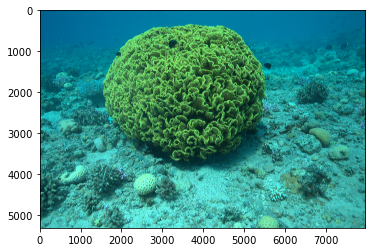

In [12]:
image = rawpy.imread(path1)
image = image.postprocess(use_camera_wb=True)

print(image.shape)
plt.imshow(image)
plt.show()

(5304, 7952)


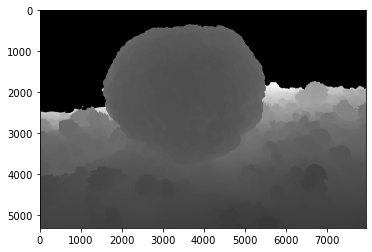

In [13]:
depth_image = Image.open(path2)
depth_image = np.array(depth_image)

print(depth_image.shape)
plt.imshow(depth_image, cmap='gray')
plt.show()

In [14]:
# https://www.geeksforgeeks.org/python-pil-image-thumbnail-method/
# used thumbnail function to preserve aspect ratio while resizing

In [15]:
def image_read(path1, path2):
    
    image = rawpy.imread(path1)
    image = image.postprocess(use_camera_wb=True)

    print(f'Initial size of image : {image.shape}')
    image = Image.fromarray(image)
    
    
    image.thumbnail((1024, 1024))
    image = np.float32(image)/255
    print(f'Final size of image : {image.shape}')

    depth_image = Image.open(path2)
    depth_image = depth_image.resize((image.shape[1], image.shape[0]))
    depth_image = np.array(depth_image)
    
    plt.imshow(image)
    plt.show()
    plt.imshow(depth_image, cmap='gray')
    plt.show()
    
    return image, depth_image

Initial size of image : (5320, 7968, 3)
Final size of image : (684, 1024, 3)


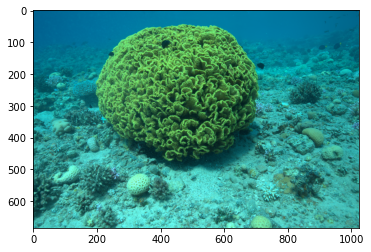

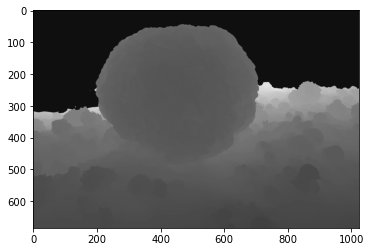

In [16]:
image, depth_image = image_read(path1, path2)

In [17]:
def backscatter_points(image, depth_image):
    max_d, min_d = np.max(depth_image), np.min(depth_image)

    arr_d = np.linspace(min_d, max_d, 11) # number of bins  = 10
    image_norms = np.mean(image, axis=2) 
    
    r, g, b = [], [], []
    
    for i in range(10):
        x, y = arr_d[i], arr_d[i+1]
        
        locs = np.where(np.logical_and(depth_image >= x, depth_image <= y))
        norms_bin, pixels_bin, depths_bin = image_norms[locs], image[locs], depth_image[locs] 
    
        arr = sorted(zip(norms_bin, pixels_bin, depths_bin, locs[0], locs[1]), key=lambda t: t[0])
        total = math.ceil(0.01*(len(arr)))
        points = arr[:total]
        
        for ele in points:
            _,_,_, x, y = ele
            image[x][y][:] = np.array([1, 0, 0])
            
        r.extend([(z, p[0]) for n, p, z, _, _ in points])
        g.extend([(z, p[1]) for n, p, z, _, _ in points])
        b.extend([(z, p[2]) for n, p, z, _, _ in points])
        
    plt.imshow(image)
    plt.show()
        
    return np.array(r), np.array(g), np.array(b)
        

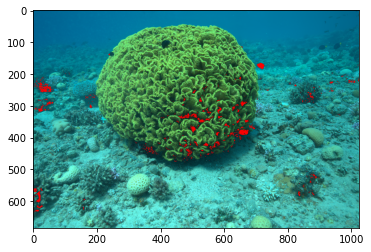

In [18]:
r, g, b = backscatter_points(image.copy(), depth_image)

In [19]:
# Backscattering parameters

# B = Backscatter for each channel
# D = Direct for each channel

In [20]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# using scipy library function called optimize curve to find the parameter of the model for backscattering.

In [21]:
# callable function that takes independent variable as first argument and rest argument as parameters
def model_estimate(z, B_inf, beta_B, J_prime, beta_D_prime):
    result = (B_inf * (1 - np.exp(-1 * beta_B * z))) + (J_prime * np.exp(-1 * beta_D_prime * z))
    return result

def loss(y, z, B_inf, beta_B, J_prime, beta_D_prime):
    result = np.mean(np.abs(y - model_estimate(z, B_inf, beta_B, J_prime, beta_D_prime)))
    return result

def Backscatter_parameters(data, depth_image):
    
    B_depths = data[:, 0]
    B_values = data[:, 1]
    
    parameters = None
    loss_value = float('inf')
    
    lower_bounds = [0, 0, 0, 0]
    upper_bounds = [1, 5, 1, 5]
    
    for _ in range(10):
        optp, pcov = sp.optimize.curve_fit(
                        f=model_estimate,
                        xdata = B_depths,
                        ydata = B_values,
                        p0 = np.random.random(4)*upper_bounds,
                        bounds = (lower_bounds, upper_bounds),
                        )
        l = loss(B_values, B_depths, *optp)
        if l < loss_value:
            loss_value = l
            parameters = optp
            
    return model_estimate(depth_image, *parameters), parameters

In [22]:
# r=red, g = green, b=blue channel

B_r, p_r = Backscatter_parameters(r, depth_image)
B_g, p_g = Backscatter_parameters(g, depth_image)
B_b, p_b = Backscatter_parameters(b, depth_image)

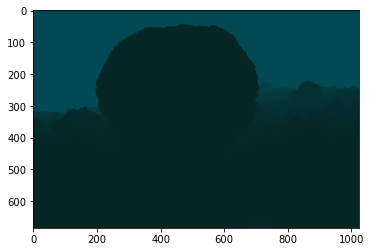

In [25]:
backscatter = np.stack([B_r, B_g, B_b], axis=2)
backscatter = np.clip(backscatter, 0, 1)
plt.imshow(backscatter)
plt.show()

In [28]:
print(np.max(backscatter))
print(np.min(backscatter))

print(np.max(image))
print(np.min(image))

0.5030141
0.0
1.0
0.0


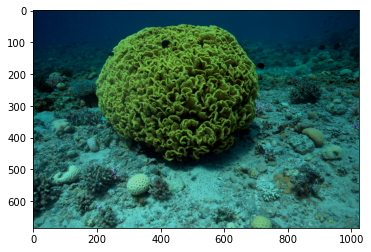

In [29]:
# removing the backscatter from original image

# I_c = D_c + B_c
# D_c = I_c - B_c

direct_image = image - backscatter
direct_image = np.clip(direct_image, 0, 1)
plt.imshow(direct_image)
plt.show()